In [1]:
# 📦 UNIR CSVs PARA MODELO DE ATRIBUCIÓN
import pyodbc         # Conexión con bases de datos SQL Server
import pandas as pd   # Manipulación y transformación de datos
import numpy as np    # Gestión de datos numéricos
import os             # Operaciones con archivos y rutas
import warnings       # Control de advertencias
import seaborn as sns
import matplotlib.pyplot as plt
# Suprimir avisos innecesarios
warnings.filterwarnings("ignore", category=UserWarning)


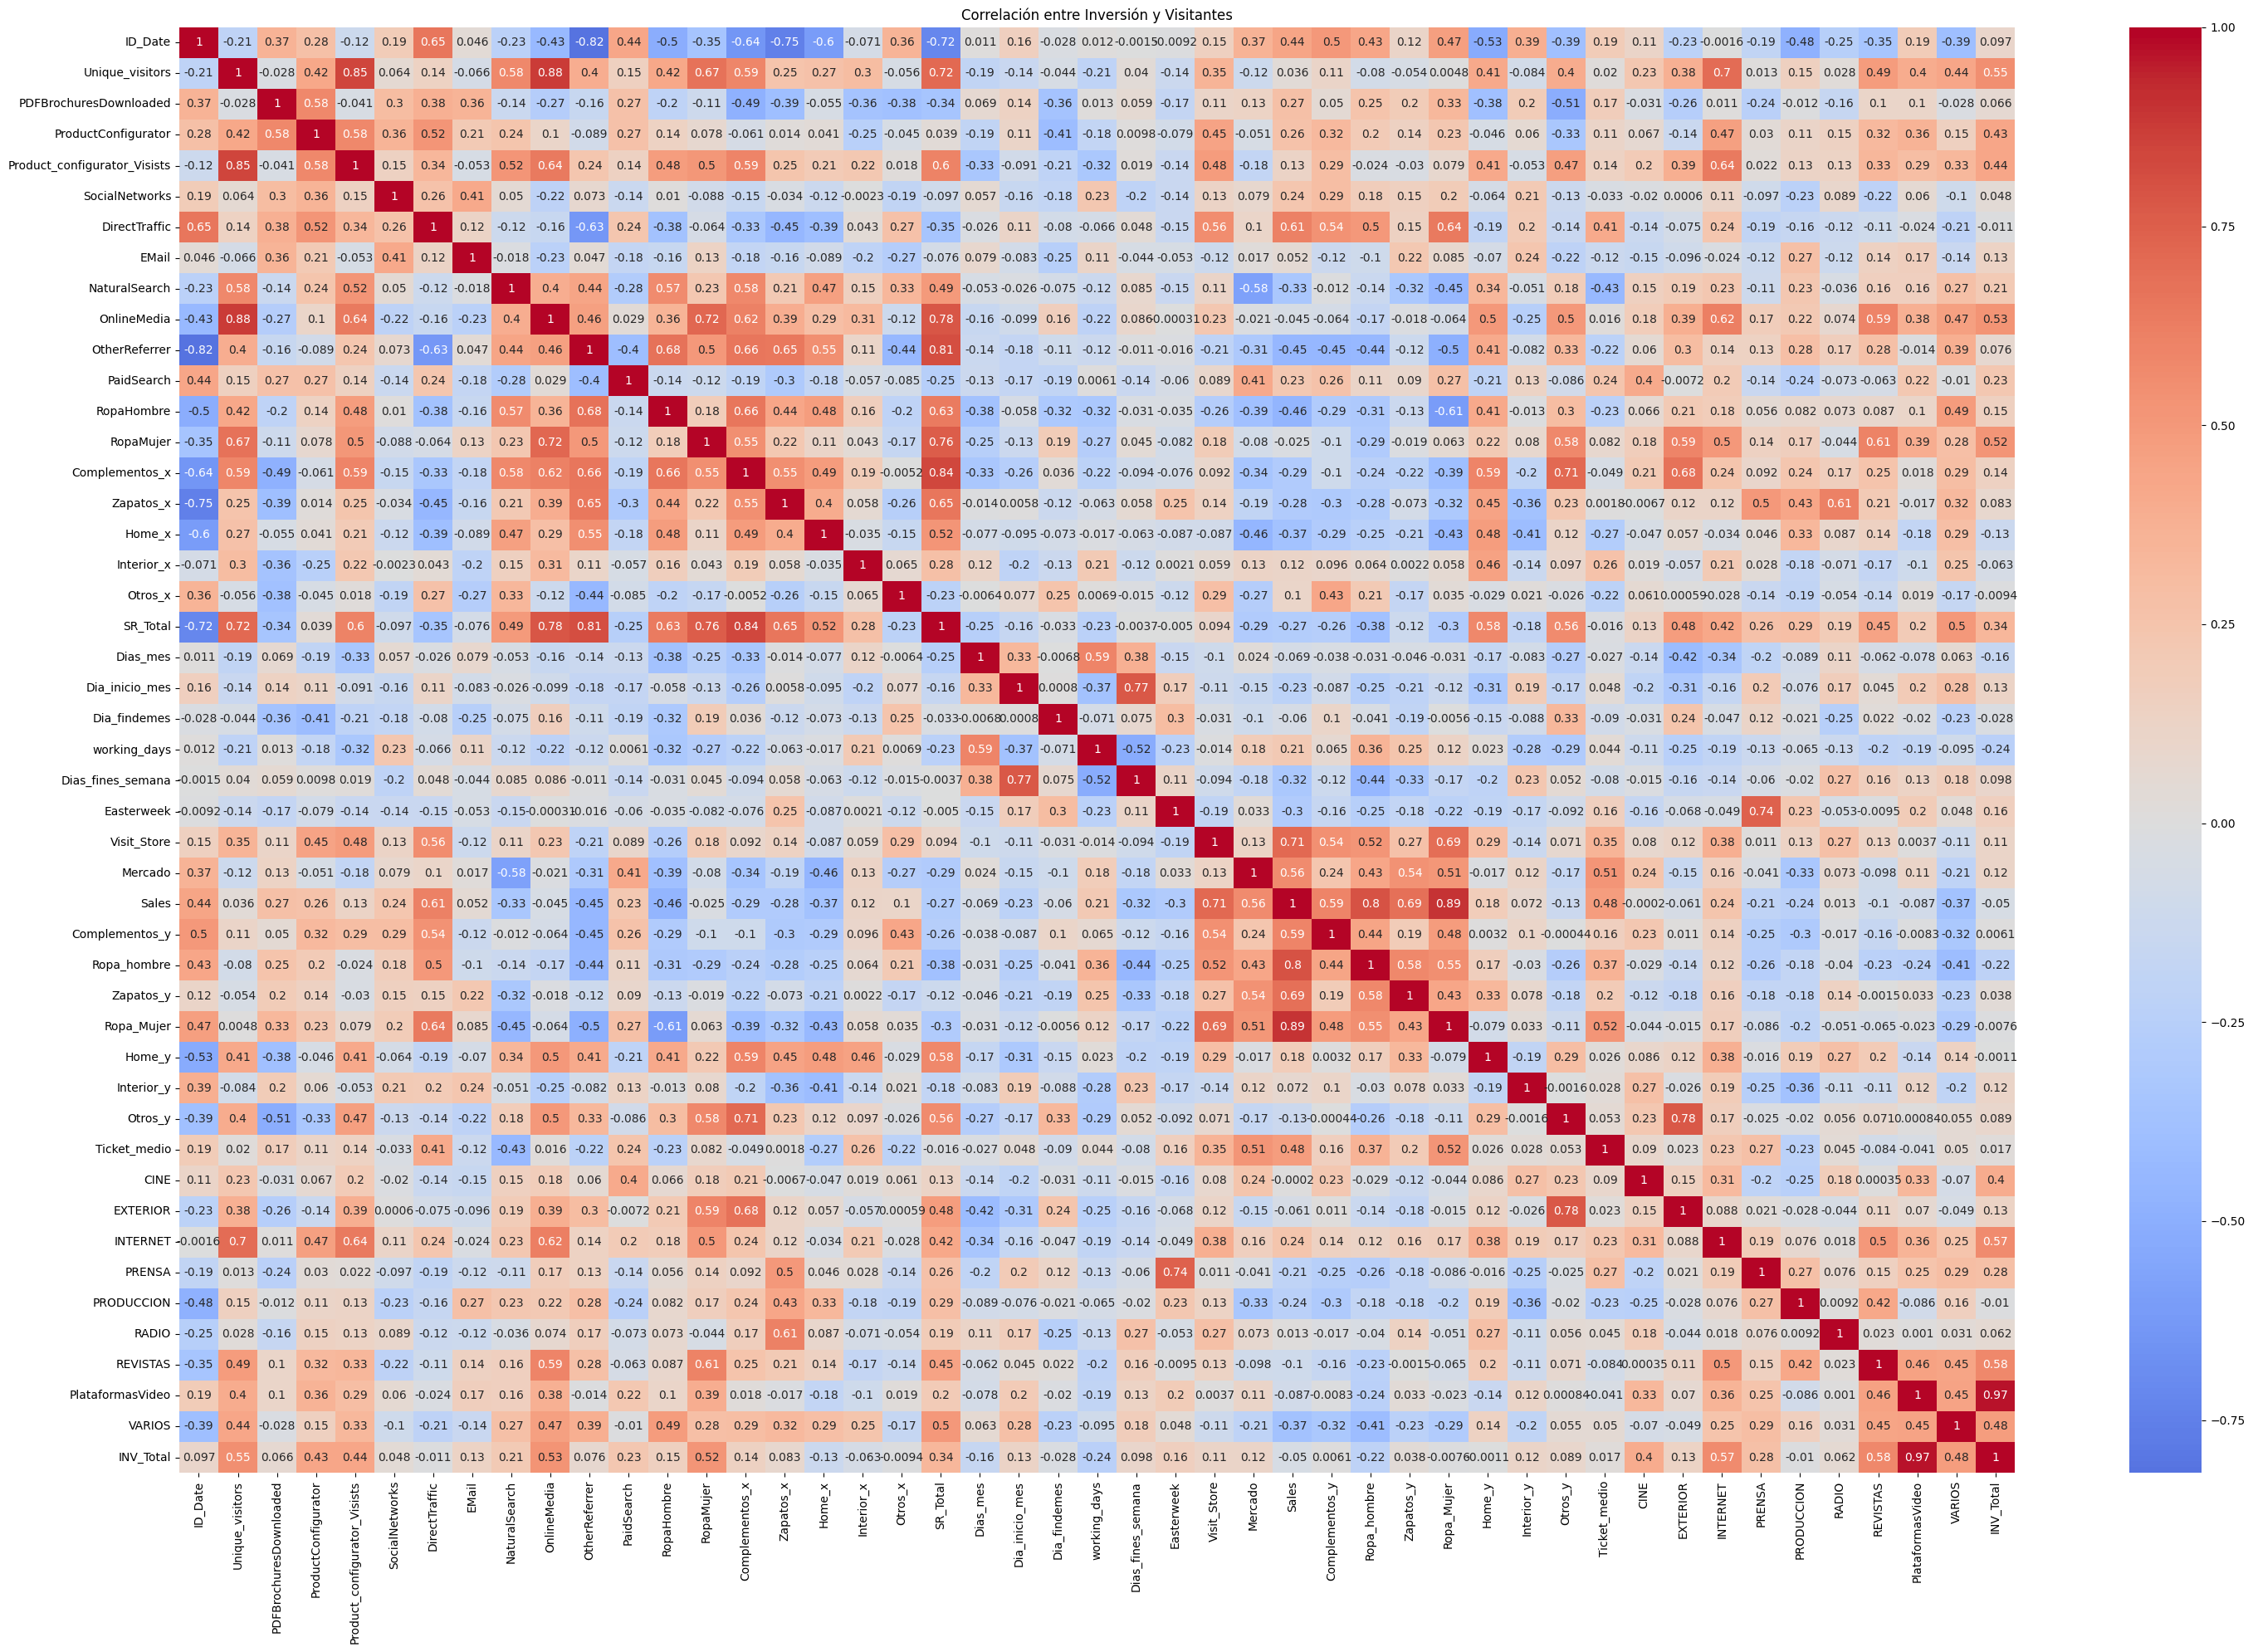

In [2]:
# Cargar los archivos CSV
df_web = pd.read_csv("data/WEB.csv")
df_visit = pd.read_csv("data/VISIT.csv")
df_time = pd.read_csv("data/TIME.csv")
df_offline = pd.read_csv("data/OFFLINE.csv")
df_inv = pd.read_csv("data/INV.csv")

# Limpiar columnas numéricas mal formateadas en INV
inv_clean = df_inv.copy()
for col in inv_clean.columns:
    if inv_clean[col].dtype == 'object' and col != 'ID_Date':
        inv_clean[col] = inv_clean[col].str.replace(',', '.', regex=False)
        inv_clean[col] = pd.to_numeric(inv_clean[col], errors='coerce')

# Unir los datasets por la columna común 'ID_Date'
df = df_web.merge(df_visit, on='ID_Date') \
        .merge(df_time, on='ID_Date') \
        .merge(df_offline, on='ID_Date') \
        .merge(inv_clean, on='ID_Date')

# Eliminar filas con valores nulos
df = df.dropna()

# Exportar el DataFrame unido a CSV (opcional)
df.to_csv("data/Modelo_Atribucion_Unificado.csv", index=False, encoding='utf-8-sig')

# Calcular matriz de correlación
corr = df.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Inversión y Visitantes')
plt.tight_layout()
plt.show()

In [3]:
df.corr().to_csv("data/Correlacion.csv", index=True, encoding='utf-8-sig')

In [4]:
# 📌 AÑADIR DELAY Y BUDGET AL MODELO DE ATRIBUCIÓN

# Delay: mover la variable de ventas una posición hacia atrás para simular su efecto retardado
df['Sales_lag'] = df['Sales'].shift(-1)

# Crear variable de ventas pasadas (para modelo autoregresivo)
df['Sales_t-1'] = df['Sales'].shift(1)

# Eliminar filas con valores nulos creados por el shift
df = df.dropna(subset=['Sales_lag', 'Sales_t-1']).reset_index(drop=True)

# Crear variables de inversión agregada por tipo
canales_online = ['PaidSearch', 'SocialNetworks', 'EMail', 'NaturalSearch', 'OnlineMedia', 'OtherReferrer']
canales_offline = ['RADIO', 'EXTERIOR', 'CINE', 'REVISTAS', 'PRENSA', 'PRODUCCION', 'VARIOS', 'INTERNET', 'PlataformasVideo']

df['inv_online'] = df[canales_online].sum(axis=1)
df['inv_offline'] = df[canales_offline].sum(axis=1)


In [5]:
# Cargar la matriz de correlación
df_corr = pd.read_csv("data/Correlacion.csv", index_col=0)

# Extraer y mostrar solo la fila de 'Sales', ordenada de mayor a menor
sales_corr = df_corr.loc['Sales'].sort_values(ascending=False)

# Mostrar resultado
print(sales_corr)

Sales                           1.000000
Ropa_Mujer                      0.894943
Ropa_hombre                     0.799824
Visit_Store                     0.713005
Zapatos_y                       0.686925
DirectTraffic                   0.613117
Complementos_y                  0.590911
Mercado                         0.564543
Ticket_medio                    0.481195
ID_Date                         0.442720
PDFBrochuresDownloaded          0.274405
ProductConfigurator             0.259939
INTERNET                        0.243111
SocialNetworks                  0.239081
PaidSearch                      0.225588
working_days                    0.214987
Home_y                          0.182781
Product_configurator_Visists    0.126808
Interior_x                      0.117267
Otros_x                         0.100038
Interior_y                      0.071522
EMail                           0.051827
Unique_visitors                 0.035715
RADIO                           0.012550
CINE            

In [6]:
target = 'Sales'
# Definir las características a utilizar en el modelo
features = [
    'Visit_Store', 'Mercado', 'Ticket_medio',
    'ID_Date', 'working_days', 'NaturalSearch'
]

X = df[features]
y = df[target]

In [7]:
# Revisar valores faltantes
print("Valores faltantes por columna:\n", df.isnull().sum())

# Si existen valores faltantes se pueden eliminar o imputar
data = df.dropna()

# Escalado de variables (opcional, pero recomendable para modelos sensibles a la escala)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en conjunto de entrenamiento y prueba para validar el modelo
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Datos preparados y divididos para entrenamiento y prueba.")

Valores faltantes por columna:
 ID_Date                         0
Unique_visitors                 0
PDFBrochuresDownloaded          0
ProductConfigurator             0
Product_configurator_Visists    0
SocialNetworks                  0
DirectTraffic                   0
EMail                           0
NaturalSearch                   0
OnlineMedia                     0
OtherReferrer                   0
PaidSearch                      0
RopaHombre                      0
RopaMujer                       0
Complementos_x                  0
Zapatos_x                       0
Home_x                          0
Interior_x                      0
Otros_x                         0
SR_Total                        0
Dias_mes                        0
Dia_inicio_mes                  0
Dia_findemes                    0
working_days                    0
Dias_fines_semana               0
Easterweek                      0
Visit_Store                     0
Mercado                         0
Sales           

In [8]:
# Celda 4: Modelado de Regresión Lineal
from sklearn.linear_model import LinearRegression

# Crear y ajustar el modelo de regresión lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# Realizar predicciones sobre el conjunto de prueba
y_pred = lr_model.predict(X_test)
# Calcular métricas de desempeño: R² y RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Evaluación del modelo de regresión lineal:")
print("R²:", r2)
print("RMSE:", rmse)

Evaluación del modelo de regresión lineal:
R²: 0.6083052394975856
RMSE: 159.69260170682273


In [10]:
import statsmodels.api as sm

# Agregar la constante (intercepto) a las variables independientes
X_const = sm.add_constant(X_scaled)

# Ajustar el modelo OLS (mínimos cuadrados ordinarios)
modelo_ols = sm.OLS(y, X_const)
resultado = modelo_ols.fit()

# Mostrar el resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     17.92
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           2.85e-08
Time:                        20:00:04   Log-Likelihood:                -213.37
No. Observations:                  34   AIC:                             440.7
Df Residuals:                      27   BIC:                             451.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1744.5000     24.744     70.502      0.0